## Imports

In [1]:
import torch
import torchvision
import torch.nn as nn

import torchvision.datasets

import torchvision.transforms as tforms

import matplotlib.pyplot as plt
import numpy as np

from tqdm import tqdm as tqdm

## Data preparation

In [2]:

channels = 3
im_size = 16

mnist_transform = tforms.Compose([
        tforms.Resize(im_size),
        tforms.ToTensor(),
        tforms.Lambda(lambda x: torch.cat([x, x, x], 0)),
        tforms.Normalize([0.5],[0.5])
    ])

train_regular_mnist = torchvision.datasets.MNIST(root="./data", train=True, transform=mnist_transform, download=True)
test_regular_mnist = torchvision.datasets.MNIST(root="./data", train=False, transform=mnist_transform, download=True)


def random_color(im):
    hue = 360*np.random.rand()
    d = (im *(hue%60)/60)
    im_min, im_inc, im_dec = torch.zeros_like(im), d, im - d
    c_im = torch.zeros((3, im.shape[1], im.shape[2]))
    H = round(hue/60) % 6    
    cmap = [[0, 3, 2], [2, 0, 3], [1, 0, 3], [1, 2, 0], [3, 1, 0], [0, 1, 2]]
    return torch.cat((im, im_min, im_dec, im_inc), dim=0)[cmap[H]]

colored_transform = tforms.Compose([
    tforms.Resize(im_size),
    tforms.ToTensor(),
    random_color,
    tforms.Normalize([0.5],[0.5])
])

train_colored_mnist = torchvision.datasets.MNIST(root="./data", train=True, transform=colored_transform, download=True)
test_colored_mnist = torchvision.datasets.MNIST(root="./data", train=False, transform=colored_transform, download=True)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


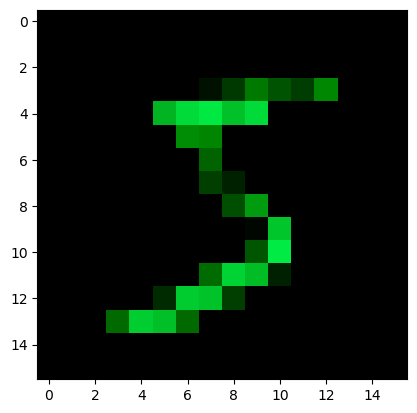

In [3]:
plt.imshow(train_colored_mnist[0][0].permute([1, 2, 0]), cmap='gray')

## Model

In [4]:
from unet import UNet

class FlowMathcing(nn.Module):
    def __init__(self):
        super().__init__()
        # CNN + positional embeding time conditioning
        # can use NN from MNIST DDPM
        self.vector_net = UNet(channels, base_channels=128, channel_mults=(1, 2, 4))
        self.euler_dt = 0.01
        
    def forward(self, x_0):
        # solve forward ODE via Euler or torchdiffeq solver
        x_t = x_0
        dt = 0.001
        
        t_range = tqdm(torch.arange(0, 1, step=self.euler_dt))
        
        for t in t_range:
            x_t = x_t + self.vector_net(x_t, t) * self.euler_dt
            
        return x_t
    
    def step(self, x_0, x_1, t):
        t = t.reshape([-1, 1, 1, 1])
        x_t = t * x_1 + (1 - t) * x_0
        x_t_hat = self.vector_net(x_t, t)
        return self.loss(x_t_hat, x_0, x_1, t).mean()
    
    def loss(self, x_t_hat, x_0, x_1, t):
        return torch.norm((x_t_hat - (x_1 - x_0)).reshape([x_0.shape[0], -1]), dim=-1)
    

In [5]:
model_unet = UNet(channels, base_channels=128, channel_mults=(1, 2, 4))

train_colored_mnist_loader = torch.utils.data.DataLoader(train_colored_mnist, batch_size=64, shuffle=True)

samples_input = next(iter(train_colored_mnist_loader))[0]

model_unet(samples_input, torch.zeros([64])).shape

torch.Size([64, 3, 16, 16])

In [27]:
# fm_model = FlowMathcing()
with torch.no_grad():
    sample_output = fm_model(sample_regular_mnist.to('cuda:1'))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 79.47it/s]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


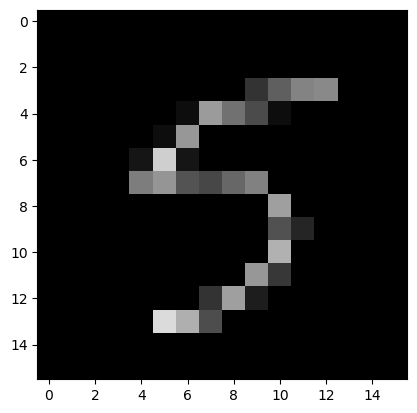

In [40]:
plt.imshow(sample_regular_mnist[15].detach().cpu().permute([1, 2, 0]), cmap='gray')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


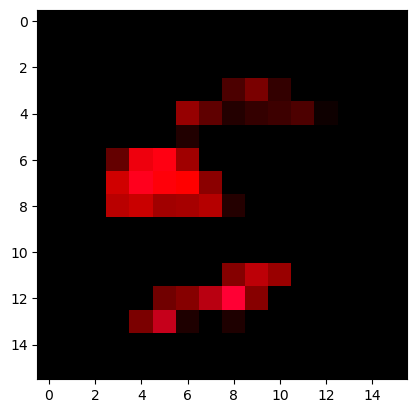

In [41]:
plt.imshow(sample_output[15].detach().cpu().permute([1, 2, 0]), cmap='gray')

## Training

In [24]:
device = 'cuda:1'
batch_size = 64
epochs = 10

train_colored_mnist_loader = torch.utils.data.DataLoader(train_colored_mnist, batch_size=batch_size, shuffle=True, drop_last=True)
train_regular_mnist_loader = torch.utils.data.DataLoader(train_regular_mnist, batch_size=batch_size, shuffle=True, drop_last=True)

fm_model = FlowMathcing()
fm_model.load_state_dict(torch.load('fm_model_colored_mnist_16.pth'))

fm_model.to(device)

opt = torch.optim.AdamW(fm_model.parameters(), lr=1e-3)

from optimal_transport import OTPlanSampler

def create_pairs_OT(batch_x_0, batch_x_1):
    ot_sampler = OTPlanSampler(method="exact")
    x0, x1 = ot_sampler.sample_plan(batch_x_0, batch_x_1)
    return x0, x1

sample_regular_mnist = next(iter(train_regular_mnist_loader))[0]
sample_colored_mnist = next(iter(train_colored_mnist_loader))[0]



In [25]:
# torch.save(fm_model.state_dict(), 'fm_model_colored_mnist_16.pth')

In [26]:
pbar = tqdm(enumerate(zip(iter(train_regular_mnist_loader), iter(train_colored_mnist_loader))))
n_epochs = 10

for epoch in range(n_epochs):
    for itr, item in enumerate(zip(iter(train_regular_mnist_loader), iter(train_colored_mnist_loader))):
    #     print(item)[0]
        ((x_0, y_0), (x_1, y_1)) = item
        x_0, x_1 = x_0.to(device), x_1.to(device)
        x0, x1 = create_pairs_OT(x_0, x_1)
        t = torch.rand(batch_size).to(device)
        loss = fm_model.step(x_0, x_1, t)

        opt.zero_grad()
        loss.backward()
        opt.step()

        if itr % 10 == 0:
            print(loss.item())

    #     pbar.set_description(f'Loss: {loss.item()}')



0it [03:31, ?it/s]


2.2417259216308594
4.808194160461426
3.5750505924224854
3.1717681884765625
3.0730581283569336
2.4383702278137207
2.2496442794799805
2.2391257286071777
2.1441030502319336
2.775629997253418
1.898245096206665
1.7123944759368896
2.3411240577697754
2.0101263523101807
2.100388288497925
2.247016429901123
2.0478134155273438
1.9762907028198242
1.9743558168411255
1.7866491079330444
1.8949732780456543
1.7999516725540161
2.2652463912963867
1.8849143981933594
1.7542672157287598
2.240236759185791
2.21689510345459
2.029503345489502
2.1066043376922607
1.9066966772079468
2.189350128173828
1.944154143333435
1.9494223594665527
2.1364264488220215
2.5766611099243164
2.261651039123535
2.15669322013855
2.280797243118286
2.0761492252349854
2.3577775955200195
2.2417662143707275
2.196549892425537
1.7116761207580566
1.968125581741333
2.027777910232544
2.587977886199951
1.9732778072357178
2.2562801837921143
2.107107639312744
1.980583667755127
2.0066163539886475
2.0449929237365723
1.7566590309143066
2.160559654235

KeyboardInterrupt: 

In [74]:

x0, x1 = create_pairs_OT(sample_regular_mnist, sample_colored_mnist)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


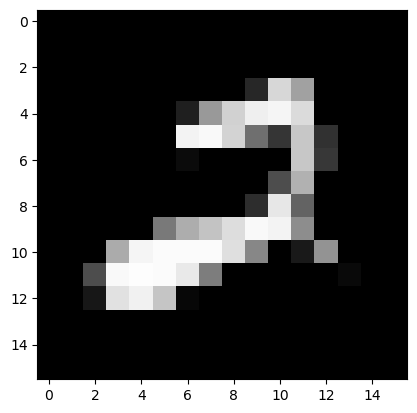

In [77]:
idx = 3
plt.imshow(x0[idx].detach().cpu().permute([1, 2, 0]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


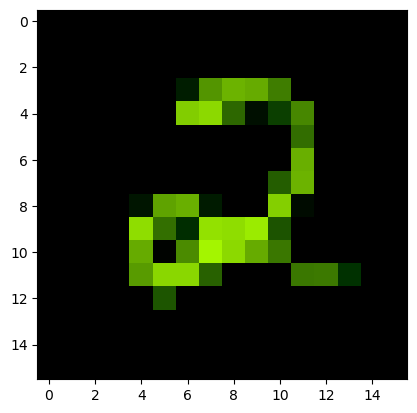

In [78]:
plt.imshow(x1[idx].detach().cpu().permute([1, 2, 0]))